# Installing the libraries

In [1]:
!pip install -q -U 'tensorflow-text==2.8.*'
!pip install -q tf-models-official==2.7.0
!pip install contractions
!pip install emoji
!pip install googletrans==3.1.0-alpha

     |████████████████████████████████| 4.9 MB 30.0 MB/s 
     |████████████████████████████████| 1.8 MB 34.4 MB/s 
     |████████████████████████████████| 1.3 MB 67.0 MB/s 
     |████████████████████████████████| 99 kB 10.9 MB/s 
     |████████████████████████████████| 116 kB 52.0 MB/s 
     |████████████████████████████████| 352 kB 50.4 MB/s 
     |████████████████████████████████| 1.1 MB 59.3 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 238 kB 60.2 MB/s 
     |████████████████████████████████| 596 kB 44.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 21.7 MB/s 
     |████████████████████████████████| 106 kB 63.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 17.1 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3

# Import the libraries

In [2]:
import os
import shutil
import pickle
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns

import string
import re
import nltk
from nltk.tokenize import word_tokenize
import contractions
from nltk.stem.porter import PorterStemmer
import googletrans
from googletrans import Translator
import emoji 

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

tf.get_logger().setLevel('ERROR')
nltk.download('punkt')
nltk.download('stopwords')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Loading the data

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/Incongruence_Data/data_text/nike.zip -d textual_data
!unzip gdrive/MyDrive/Incongruence_Data/data_text/gucci.zip -d textual_data
!unzip gdrive/MyDrive/Incongruence_Data/data_text/cristianoronaldo.zip -d textual_data
!unzip gdrive/MyDrive/Incongruence_Data/data_text/edsheeran.zip -d textual_data

# Preprocessing

In [5]:
def get_data_files(path, textual_data):
  a = 0
  translator = Translator()
  for folder in os.listdir(path):
      for file in os.listdir(path + folder):
          f = open(path+folder+'/'+file, encoding='UTF-8')
          text = f.read()
          # Get only English captions
          result = translator.translate(text)
          if result.src != 'en':
            caption = result.text
          else:
            caption = text
          textual_data.append([file, text, caption, 1])
          a += 1
          print(f'{a}/{len(os.listdir(path))}')
  return textual_data

In [6]:
# Creating a dataframe for each hashtags and save as a pickle to avoid time-consuming process
def create_dataframe(name):
  path_match = 'textual_data/' + name + '/Matches/'
  path_mismatch = 'textual_data/' + name + '/Mismatches/'
  textual_data = []
  textual_data = get_data_files(path_match, textual_data)
  textual_data = get_data_files(path_mismatch, textual_data)
  with open('gdrive/MyDrive/Incongruence_Data/data_text/' + name + '_data_list.pickle', 'wb') as handle:
      pickle.dump(textual_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# hashtags = ['cristianoronaldo', 'edsheeran', 'gucci', 'nike']
# for name in hashtags:
#   create_dataframe(name)

In [7]:
def get_df(name):
  with open('gdrive/MyDrive/Incongruence_Data/data_text/' + name + '_data_list.pickle', 'rb') as handle:
    data = pickle.load(handle)
  df = pd.DataFrame(data, columns=['file_name', 'caption2', 'caption', 'class'])
  df.drop(columns=['caption2'], inplace=True)
  return df

In [8]:
def preprocess(df):

  # Lowering the text
  df['caption'] = df['caption'].apply(lambda x: x.lower())

  # Expand Contractions
  contractions_text = []
  for caption in df['caption'].values:
    expanded_words = []   
    for word in caption.split():
      expanded_words.append(contractions.fix(word))  
    contractions_text.append(' '.join(expanded_words))
  df['caption'] = contractions_text

  # Emoji Conversion
  df['caption'] = df['caption'].apply(lambda x: emoji.demojize(x))
  df['caption'] = df['caption'].apply(lambda x: x.replace(':', ' '))

  # Punctuation Removal
  # data = []
  # special_punctuation = '#_@:.【】'
  # for caption in df['caption'].values:
  #   for char in caption:
  #     if char in string.punctuation:
  #       if char in special_punctuation:
  #         caption = caption.replace(char, ' ')
  #       else:
  #         caption = caption.replace(char, '')
  #   data.append(caption)
  # df['caption'] = data

  # Tokenization
  # df['tokenized_caption'] = df['caption'].apply(lambda x: word_tokenize(x))

  # Stop word removal
  # stopwords = nltk.corpus.stopwords.words('english')
  # df['tokenized_caption'] = df['tokenized_caption'].apply(lambda x:[i for i in x if i not in stopwords])

  # Stemming
  # porter_stemmer = PorterStemmer()
  # df['tokenized_caption'] = df['tokenized_caption'].apply(lambda x: [porter_stemmer.stem(word) for word in x])
  # df['caption'] = df['tokenized_caption'].apply(lambda x: ' '.join(x))

  # df.drop(columns=['tokenized_caption'], inplace=True)

  return df

In [9]:
def load_ocr_text(df, name):
  ocr_text = []
  a = 0
  file_num = len(df['file_name'].values)
  for data in df['file_name'].values:
    flag = False
    new_data_name = data.split('UTC')[0]
    if new_data_name in os.listdir('gdrive/MyDrive/Incongruence_Data/data_text/OCR data/' + name + '_match_OCR_output/'):
      flag = True
      text = ''
      for match_data in os.listdir('gdrive/MyDrive/Incongruence_Data/data_text/OCR data/' + name + '_match_OCR_output/' + new_data_name):
        f = open('gdrive/MyDrive/Incongruence_Data/data_text/OCR data/' + name + '_match_OCR_output/' + new_data_name + '/' + match_data, encoding='UTF-8')
        text += f.read()
      ocr_text.append(text)
      f.close()

    elif new_data_name in os.listdir('gdrive/MyDrive/Incongruence_Data/data_text/OCR data/' + name + '_mismatch_OCR_output/'):
      if not flag:
        text = ''
        for mismatch_data in os.listdir('gdrive/MyDrive/Incongruence_Data/data_text/OCR data/' + name + '_mismatch_OCR_output/' + new_data_name):
          f = open('gdrive/MyDrive/Incongruence_Data/data_text/OCR data/' + name + '_mismatch_OCR_output/' + new_data_name + '/' + mismatch_data, encoding='UTF-8')
          text += f.read()
        ocr_text.append(text)
        f.close()  
    a += 1
    print(f'{a}/{file_num}')

    # if name == '':
    #   ocr_text.append('cristianoronaldo')
  
  with open('gdrive/MyDrive/Incongruence_Data/data_text/' + name + '_data_OCR.pickle', 'wb') as handle:
      pickle.dump(ocr_text, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
def get_ocr_text(name):
  with open('gdrive/MyDrive/Incongruence_Data/data_text/' + name + '_data_OCR.pickle', 'rb') as handle:
    data = pickle.load(handle)
  return data

In [11]:
def preprocess_ocr(df):
  # Lowering the text
  df['ocr_text'] = df['ocr_text'].apply(lambda x: x.lower())

  # Expand Contractions
  contractions_text = []
  for caption in df['ocr_text'].values:
    expanded_words = []   
    for word in caption.split():
      expanded_words.append(contractions.fix(word))  
    contractions_text.append(' '.join(expanded_words))
  df['ocr_text'] = contractions_text

  # Punctuation Removal
  # data = []
  # special_punctuation = '#_@:.【】'
  # for caption in df['ocr_text'].values:
  #   for char in caption:
  #     if char in string.punctuation:
  #       if char in special_punctuation:
  #         caption = caption.replace(char, ' ')
  #       else:
  #         caption = caption.replace(char, '')
  #   data.append(caption)
  # df['ocr_text'] = data

  # Tokenization
  # df['tokenized_ocr'] = df['ocr_text'].apply(lambda x: word_tokenize(x))

  # Stop word removal
  # stopwords = nltk.corpus.stopwords.words('english')
  # df['tokenized_ocr'] = df['tokenized_ocr'].apply(lambda x:[i for i in x if i not in stopwords])

  # Stemming
  # porter_stemmer = PorterStemmer()
  # df['tokenized_ocr'] = df['tokenized_ocr'].apply(lambda x: [porter_stemmer.stem(word) for word in x])
  # df['ocr_text'] = df['tokenized_ocr'].apply(lambda x: ' '.join(x))

  # df.drop(columns=['tokenized_ocr'], inplace=True)
  
  return df

In [12]:
df_cristianoronaldo = get_df('cristianoronaldo')
df_edsheeran = get_df('edsheeran')
df_gucci = get_df('gucci')
df_nike = get_df('nike')

In [13]:
df_nike = preprocess(df_nike)
df_cristianoronaldo = preprocess(df_cristianoronaldo)
df_gucci = preprocess(df_gucci)
df_edsheeran = preprocess(df_edsheeran)

In [14]:
# load_ocr_text(df_nike, 'nike')
# load_ocr_text(df_cristianoronaldo, 'cristianoronaldo')
# load_ocr_text(df_gucci, 'gucci')
# load_ocr_text(df_edsheeran, 'edsheeran')

ocr_list_nike = get_ocr_text('nike')
ocr_list_cristianoronaldo = get_ocr_text('cristianoronaldo')
ocr_list_cristianoronaldo.append('')
ocr_list_gucci = get_ocr_text('gucci')
ocr_list_edsheeran = get_ocr_text('edsheeran')

df_nike['ocr_text'] = ocr_list_nike
df_cristianoronaldo['ocr_text'] = ocr_list_cristianoronaldo
df_gucci['ocr_text'] = ocr_list_gucci
df_edsheeran['ocr_text'] = ocr_list_edsheeran

In [15]:
df_nike = preprocess_ocr(df_nike)
df_cristianoronaldo = preprocess_ocr(df_cristianoronaldo)
df_gucci = preprocess_ocr(df_gucci)
df_edsheeran = preprocess_ocr(df_edsheeran)

In [16]:
df = df_nike.append([df_gucci, df_cristianoronaldo, df_edsheeran])

In [ ]:
a = df[df['ocr_text'] == ''].shape[0]
b = df[df['ocr_text'] != ''].shape[0]
print(f'Number of data without OCR texts: {a}')
print(f'Number of data with OCR texts: {b}')

Number of data without OCR texts: 5881
Number of data with OCR texts: 8159


# Model Training (without OCR)

## Load the Bert model

In [17]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_model_path = map_name_to_handle[bert_model_name]
bert_preprocess_path = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', bert_model_path)
print('Preprocessing model auto-selected:', bert_preprocess_path)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Bert preprocess model

In [18]:
# input_segments = [tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in ['caption', 'OCR']]
input_segments = tf.keras.layers.Input(shape=(), dtype=tf.string, name='caption')
bert_preprocess = hub.load(bert_preprocess_path)
tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
# segments = [tokenizer(s) for s in input_segments]
truncated_segments = [tokenizer(input_segments)]
packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs, arguments=dict(seq_length=128), name='packer')
model_inputs = packer(truncated_segments)
bert_preprocess_model = keras.Model(input_segments, model_inputs)

### Preprocess a sample data

In [ ]:
idx = np.random.choice(len(df))
sample_caption = df.iloc[idx]['caption']
print(f"Caption: {sample_caption}")

text_preprocessed = bert_preprocess_model(np.array([sample_caption]))

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])

Caption: nike sports shorts, size xs, but also fits s, condition 9/10, 200,- #jestejednoudokola#sekac#zdruheruky#zdruhejruky#sport#nike#czechgirl#ceskaholka#slovakgirl#recycling
Keys           :  ['input_type_ids', 'input_word_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101 18368  2998  9132  1010  2946  1060  2015  1010  2021  2036 16142
  1055  1010  4650  1023], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [19]:
def preprocess_text(sample):
  caption = tf.convert_to_tensor([sample['caption']])
  output = bert_preprocess_model(caption)
  text = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return {'text': text}

In [20]:
auto = tf.data.AUTOTUNE
batch_size = 32

def prepare_dataset(dataframe, training=True):
  columns = ['caption', 'class']
  dataframe = dataframe[columns].copy()
  labels = dataframe.pop('class')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  ds = ds.shuffle(buffer_size=len(dataframe))

  if training:
      ds = ds.shuffle(len(dataframe))
  ds = ds.map(lambda x, y: (preprocess_text(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

## Building the Bert model

In [21]:
bert_input_features = ['input_word_ids', 'input_type_ids', 'input_mask']
text_inputs = {feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature) for feature in bert_input_features}

In [22]:
bert = hub.KerasLayer(bert_model_path, name='bert')
bert.trainable = False
embeddings = bert(text_inputs)['pooled_output']
projected_embeddings = keras.layers.Dense(units = 256)(embeddings)
x = tf.nn.gelu(projected_embeddings)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Add()([projected_embeddings, x])
projected_embeddings = keras.layers.LayerNormalization()(x)
outputs = projected_embeddings
text_encoder = keras.Model(text_inputs, outputs, name='text_encoder')
text_projections = text_encoder(text_inputs)
final_outputs = keras.layers.Dense(1, activation='sigmoid')(text_projections)
model = keras.Model([text_inputs], final_outputs)

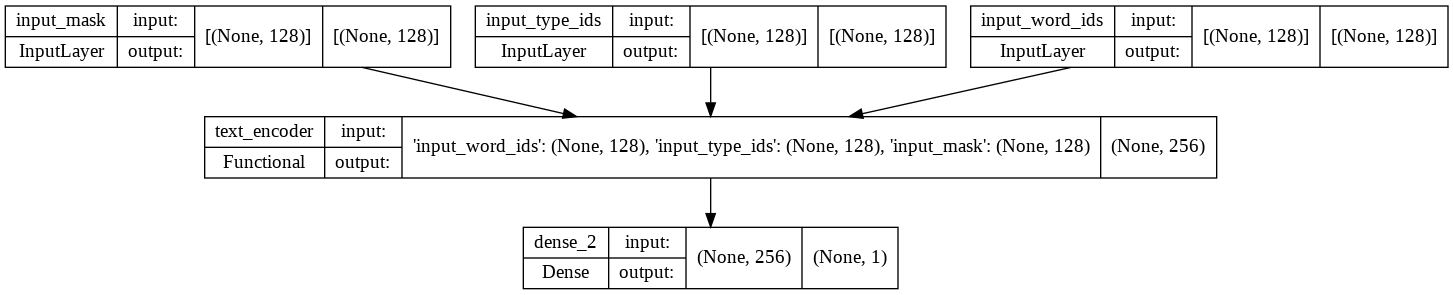

In [23]:
keras.utils.plot_model(model, show_shapes=True)

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]

## Nike

### Split data into training, testing, validation

In [25]:
train_df, test_df = train_test_split(df_nike, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 2736
Total validation examples: 305
Total test examples: 338


In [26]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

### Training the model

In [ ]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100
86/86 [==============================] - 30s 322ms/step - loss: 0.6118 - accuracy: 0.6725 - val_loss: 0.5968 - val_accuracy: 0.6918
Epoch 2/100
86/86 [==============================] - 28s 330ms/step - loss: 0.5960 - accuracy: 0.6879 - val_loss: 0.6492 - val_accuracy: 0.6295
Epoch 3/100
86/86 [==============================] - 30s 353ms/step - loss: 0.5950 - accuracy: 0.6871 - val_loss: 0.6281 - val_accuracy: 0.6590
Epoch 4/100
86/86 [==============================] - 30s 346ms/step - loss: 0.5905 - accuracy: 0.6959 - val_loss: 0.6174 - val_accuracy: 0.6721
Epoch 5/100
86/86 [==============================] - 29s 340ms/step - loss: 0.5868 - accuracy: 0.6999 - val_loss: 0.6156 - val_accuracy: 0.6721
Epoch 6/100
86/86 [==============================] - 30s 349ms/step - loss: 0.5833 - accuracy: 0.6988 - val_loss: 0.6535 - val_accuracy: 0.6393
Epoch 7/100
86/86 [==============================] - 30s 352ms/step - loss: 0.5832 - accuracy: 0.7021 - val_loss: 0.6049 - val_accuracy:

### Evaluating the model

In [ ]:
model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model.evaluate(test_ds)

11/11 [==============================] - 4s 282ms/step - loss: 0.5028 - accuracy: 0.7546


[0.5027983903884888, 0.7545561957359314]

## Ed Sheeran

### Split data into training, testing, validation

In [ ]:
train_df, test_df = train_test_split(df_edsheeran, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 2359
Total validation examples: 263
Total test examples: 292


In [ ]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

### Training the model

In [ ]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100
74/74 [==============================] - 34s 325ms/step - loss: 0.6765 - accuracy: 0.6694 - val_loss: 0.5579 - val_accuracy: 0.7023
Epoch 2/100
74/74 [==============================] - 23s 311ms/step - loss: 0.4494 - accuracy: 0.7897 - val_loss: 0.5366 - val_accuracy: 0.7479
Epoch 3/100
74/74 [==============================] - 23s 318ms/step - loss: 0.4047 - accuracy: 0.8109 - val_loss: 0.5125 - val_accuracy: 0.7669
Epoch 4/100
74/74 [==============================] - 23s 316ms/step - loss: 0.3797 - accuracy: 0.8237 - val_loss: 0.4967 - val_accuracy: 0.7669
Epoch 5/100
74/74 [==============================] - 24s 321ms/step - loss: 0.3664 - accuracy: 0.8317 - val_loss: 0.4911 - val_accuracy: 0.7745
Epoch 6/100
74/74 [==============================] - 24s 318ms/step - loss: 0.3538 - accuracy: 0.8364 - val_loss: 0.4882 - val_accuracy: 0.7745
Epoch 7/100
74/74 [==============================] - 23s 316ms/step - loss: 0.3477 - accuracy: 0.8376 - val_loss: 0.4921 - val_accuracy:

### Evaluating the model

In [ ]:
model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model.evaluate(test_ds)

10/10 [==============================] - 3s 241ms/step - loss: 0.4497 - accuracy: 0.8262


[0.44965622663497925, 0.8261643958091736]

## Gucci

### Split data into training, testing, validation

In [ ]:
train_df, test_df = train_test_split(df_gucci, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 2821
Total validation examples: 314
Total test examples: 349


In [ ]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

### Training the model

In [ ]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100
89/89 [==============================] - 39s 344ms/step - loss: 0.7352 - accuracy: 0.6597 - val_loss: 0.5860 - val_accuracy: 0.7229
Epoch 2/100
89/89 [==============================] - 29s 322ms/step - loss: 0.6145 - accuracy: 0.6838 - val_loss: 0.5626 - val_accuracy: 0.7357
Epoch 3/100
89/89 [==============================] - 29s 326ms/step - loss: 0.6060 - accuracy: 0.6898 - val_loss: 0.5447 - val_accuracy: 0.7452
Epoch 4/100
89/89 [==============================] - 29s 325ms/step - loss: 0.5963 - accuracy: 0.6948 - val_loss: 0.5353 - val_accuracy: 0.7420
Epoch 5/100
89/89 [==============================] - 29s 322ms/step - loss: 0.5858 - accuracy: 0.6987 - val_loss: 0.5281 - val_accuracy: 0.7484
Epoch 6/100
89/89 [==============================] - 29s 328ms/step - loss: 0.5773 - accuracy: 0.7012 - val_loss: 0.5244 - val_accuracy: 0.7325
Epoch 7/100
89/89 [==============================] - 29s 323ms/step - loss: 0.5724 - accuracy: 0.7058 - val_loss: 0.5159 - val_accuracy:

### Evaluating the model

In [ ]:
model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model.evaluate(test_ds)

11/11 [==============================] - 4s 261ms/step - loss: 0.5297 - accuracy: 0.7490


[0.5297412061691284, 0.7490257883071899]

## Cristiano Ronaldo

### Split data into training, testing, validation

In [ ]:
train_df, test_df = train_test_split(df_cristianoronaldo, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 3452
Total validation examples: 384
Total test examples: 427


In [ ]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

### Training the model

In [ ]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100
108/108 [==============================] - 44s 311ms/step - loss: 0.6744 - accuracy: 0.6996 - val_loss: 0.5049 - val_accuracy: 0.7630
Epoch 2/100
108/108 [==============================] - 34s 311ms/step - loss: 0.4899 - accuracy: 0.7526 - val_loss: 0.4936 - val_accuracy: 0.7604
Epoch 3/100
108/108 [==============================] - 34s 316ms/step - loss: 0.4603 - accuracy: 0.7714 - val_loss: 0.4776 - val_accuracy: 0.7552
Epoch 4/100
108/108 [==============================] - 35s 320ms/step - loss: 0.4451 - accuracy: 0.7845 - val_loss: 0.4698 - val_accuracy: 0.7630
Epoch 5/100
108/108 [==============================] - 35s 327ms/step - loss: 0.4348 - accuracy: 0.7891 - val_loss: 0.4680 - val_accuracy: 0.7552
Epoch 6/100
108/108 [==============================] - 36s 332ms/step - loss: 0.4238 - accuracy: 0.7975 - val_loss: 0.4600 - val_accuracy: 0.7630
Epoch 7/100
108/108 [==============================] - 36s 333ms/step - loss: 0.4155 - accuracy: 0.8039 - val_loss: 0.4606 -

### Evaluating the model

In [ ]:
model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model.evaluate(test_ds)

14/14 [==============================] - 4s 252ms/step - loss: 0.4416 - accuracy: 0.8244


[0.4415518641471863, 0.824355959892273]

# Model Training (with OCR)

## Load the Bert model

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_model_path = map_name_to_handle[bert_model_name]
bert_preprocess_path = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', bert_model_path)
print('Preprocessing model auto-selected:', bert_preprocess_path)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Bert preprocess model

In [ ]:
input_segments = [tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in ['caption', 'OCR']]
bert_preprocess = hub.load(bert_preprocess_path)
tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
segments = [tokenizer(s) for s in input_segments]
truncated_segments = segments
packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs, arguments=dict(seq_length=128), name='packer')
model_inputs = packer(truncated_segments)
bert_preprocess_model = keras.Model(input_segments, model_inputs)

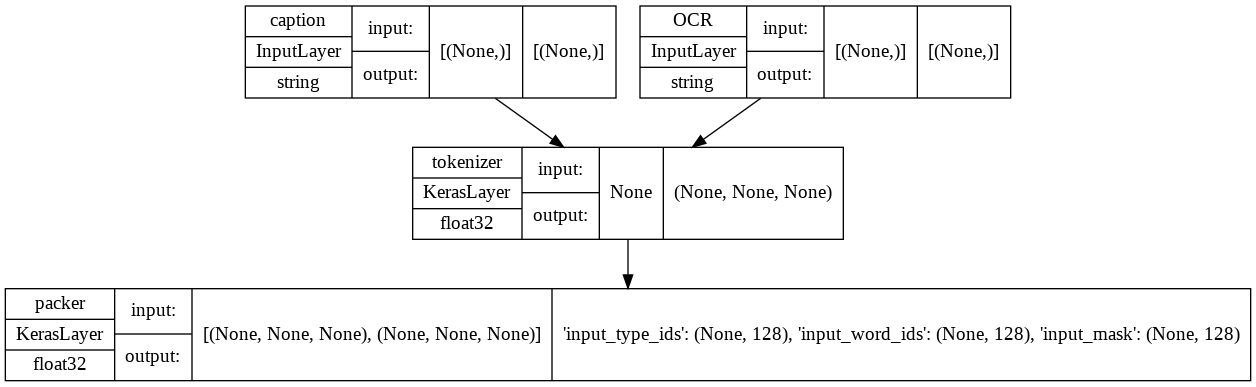

In [ ]:
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

### Preprocess a sample data

In [ ]:
test_df = df[df['ocr_text'] != '']
row = test_df.iloc[8097]
sample_text_1, sample_text_2 = row['caption'], row['ocr_text']
print(f"Caption: {sample_text_1}")
print(f"OCR: {sample_text_2}")

test_text = [np.array([sample_text_1]), np.array([sample_text_2])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])

Caption: still fanci big stadium concert summer smile face heartey problem tell date miss rais hand swipe highlight sign horn concert tip backhand index point right link bio camera pixabay camera eliot lee hazel camera gun n rosestour promo camera j bouquet eventsat event wien vienna igersvienna viennac concert concert tip imaginedragon gunsnros rollingston pictur book edsheeran ernsthappelstadion summer stadiumconcert
OCR: 13 jul 2022 gun n rose ernst happel stadion event dies stadionkonzert erwarten un sommer noch event 23 jun 2022 imagin dragon event 15 jul 2022 stone wienkonzert mit bilderbuch al cial guest ernst happel stadion event roll spe weiter highlight findest du link der biol event
Keys           :  ['input_type_ids', 'input_word_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2145 5470 6895 2502 3346 4164 2621 2868 2227 2540 3240 3291 2425
 3058 3335], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 

In [ ]:
def preprocess_text(sample):
  text_1 = sample['caption']
  text_2 = sample['ocr_text']
  text_1 = tf.convert_to_tensor([text_1])
  text_2 = tf.convert_to_tensor([text_2])
  output = bert_preprocess_model([text_1, text_2])
  text = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return {'text': text}

In [ ]:
auto = tf.data.AUTOTUNE
batch_size = 32

def prepare_dataset(dataframe, training=True):
  columns = ['caption', 'ocr_text', 'class']
  dataframe = dataframe[columns].copy()
  labels = dataframe.pop('class')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  ds = ds.shuffle(buffer_size=len(dataframe))

  if training:
      ds = ds.shuffle(len(dataframe))
  ds = ds.map(lambda x, y: (preprocess_text(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

## Building the Bert model

In [ ]:
bert_input_features = ['input_word_ids', 'input_type_ids', 'input_mask']
text_inputs = {feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature) for feature in bert_input_features}

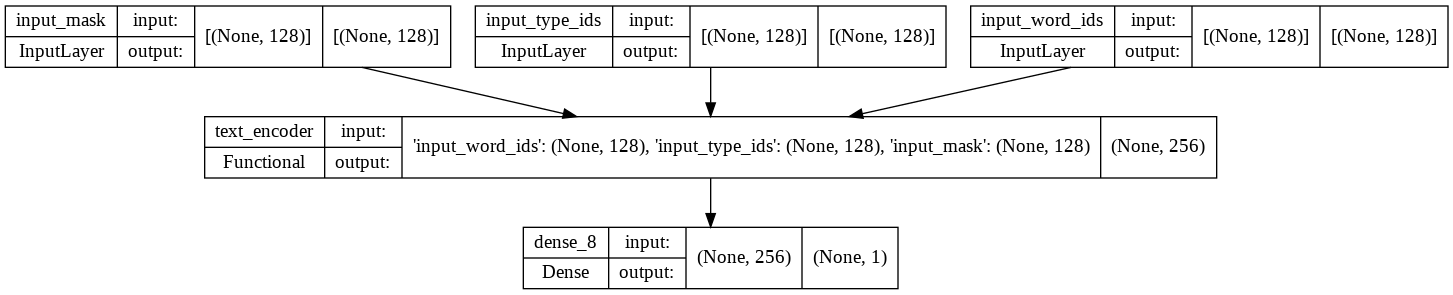

In [ ]:
bert = hub.KerasLayer(bert_model_path, name='bert')
bert.trainable = False
embeddings = bert(text_inputs)['pooled_output']
projected_embeddings = keras.layers.Dense(units = 256)(embeddings)
x = tf.nn.gelu(projected_embeddings)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Add()([projected_embeddings, x])
projected_embeddings = keras.layers.LayerNormalization()(x)
outputs = projected_embeddings
text_encoder = keras.Model(text_inputs, outputs, name='text_encoder')
text_projections = text_encoder(text_inputs)
final_outputs = keras.layers.Dense(1, activation='sigmoid')(text_projections)
model = keras.Model([text_inputs], final_outputs)

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]

## Nike

### Split data into training, testing, validation

In [ ]:
train_df, test_df = train_test_split(df_nike, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 2736
Total validation examples: 305
Total test examples: 338


In [ ]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

### Training the model

In [ ]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100
86/86 [==============================] - 37s 328ms/step - loss: 0.8258 - accuracy: 0.5256 - val_loss: 0.6970 - val_accuracy: 0.5148
Epoch 2/100
86/86 [==============================] - 28s 324ms/step - loss: 0.7108 - accuracy: 0.5234 - val_loss: 0.6928 - val_accuracy: 0.5377
Epoch 3/100
86/86 [==============================] - 29s 335ms/step - loss: 0.7011 - accuracy: 0.5395 - val_loss: 0.6930 - val_accuracy: 0.5213
Epoch 4/100
86/86 [==============================] - 30s 348ms/step - loss: 0.6989 - accuracy: 0.5424 - val_loss: 0.6913 - val_accuracy: 0.5279
Epoch 5/100
86/86 [==============================] - 30s 345ms/step - loss: 0.6968 - accuracy: 0.5450 - val_loss: 0.6847 - val_accuracy: 0.5705
Epoch 6/100
86/86 [==============================] - 30s 347ms/step - loss: 0.6918 - accuracy: 0.5442 - val_loss: 0.6819 - val_accuracy: 0.5902
Epoch 7/100
86/86 [==============================] - 30s 353ms/step - loss: 0.6893 - accuracy: 0.5490 - val_loss: 0.6795 - val_accuracy:

### Evaluating the model

In [ ]:
# fix


model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model.evaluate(test_ds)

22/22 [==============================] - 7s 311ms/step - loss: 0.4924 - accuracy: 0.7789


[0.4923655915260315, 0.7788809323310852]

## Ed Sheeran

### Split data into training, testing, validation

In [ ]:
train_df, test_df = train_test_split(df_edsheeran, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 2359
Total validation examples: 263
Total test examples: 292


In [ ]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

### Training the model

In [ ]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100
74/74 [==============================] - 38s 323ms/step - loss: 0.7656 - accuracy: 0.6036 - val_loss: 0.6365 - val_accuracy: 0.6392
Epoch 2/100
74/74 [==============================] - 23s 316ms/step - loss: 0.5756 - accuracy: 0.6994 - val_loss: 0.5069 - val_accuracy: 0.7419
Epoch 3/100
74/74 [==============================] - 24s 328ms/step - loss: 0.4936 - accuracy: 0.7554 - val_loss: 0.5010 - val_accuracy: 0.7381
Epoch 4/100
74/74 [==============================] - 24s 327ms/step - loss: 0.4758 - accuracy: 0.7588 - val_loss: 0.4819 - val_accuracy: 0.7609
Epoch 5/100
74/74 [==============================] - 24s 324ms/step - loss: 0.4546 - accuracy: 0.7643 - val_loss: 0.4674 - val_accuracy: 0.7837
Epoch 6/100
74/74 [==============================] - 24s 325ms/step - loss: 0.4512 - accuracy: 0.7656 - val_loss: 0.4437 - val_accuracy: 0.7685
Epoch 7/100
74/74 [==============================] - 24s 328ms/step - loss: 0.4345 - accuracy: 0.7830 - val_loss: 0.4464 - val_accuracy:

### Evaluating the model

In [ ]:
model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model.evaluate(test_ds)

10/10 [==============================] - 3s 262ms/step - loss: 0.3572 - accuracy: 0.8364


[0.3571843886375427, 0.8364383292198181]

## Gucci

### Split data into training, testing, validation

In [ ]:
train_df, test_df = train_test_split(df_gucci, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 2821
Total validation examples: 314
Total test examples: 349


In [ ]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

### Training the model

In [ ]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=100)

Epoch 1/100
89/89 [==============================] - 37s 322ms/step - loss: 0.7434 - accuracy: 0.6547 - val_loss: 0.5795 - val_accuracy: 0.7325
Epoch 2/100
89/89 [==============================] - 27s 302ms/step - loss: 0.6132 - accuracy: 0.6827 - val_loss: 0.5972 - val_accuracy: 0.7389
Epoch 3/100
89/89 [==============================] - 27s 309ms/step - loss: 0.5930 - accuracy: 0.6877 - val_loss: 0.6243 - val_accuracy: 0.7038
Epoch 4/100
89/89 [==============================] - 28s 309ms/step - loss: 0.5817 - accuracy: 0.6920 - val_loss: 0.6027 - val_accuracy: 0.7038
Epoch 5/100
89/89 [==============================] - 28s 316ms/step - loss: 0.5709 - accuracy: 0.6990 - val_loss: 0.5792 - val_accuracy: 0.7070
Epoch 6/100
89/89 [==============================] - 29s 322ms/step - loss: 0.5636 - accuracy: 0.7005 - val_loss: 0.5604 - val_accuracy: 0.7357
Epoch 7/100
89/89 [==============================] - 28s 319ms/step - loss: 0.5553 - accuracy: 0.7132 - val_loss: 0.5666 - val_accuracy:

### Evaluating the model

In [ ]:
model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model.evaluate(test_ds)

11/11 [==============================] - 4s 287ms/step - loss: 0.4202 - accuracy: 0.8235


[0.420244128704071, 0.8235243821144104]

## Cristiano Ronaldo

### Split data into training, testing, validation

In [ ]:
train_df, test_df = train_test_split(df_cristianoronaldo, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 3452
Total validation examples: 384
Total test examples: 427


In [ ]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

### Training the model

In [ ]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100
108/108 [==============================] - 47s 341ms/step - loss: 0.5941 - accuracy: 0.7378 - val_loss: 0.5102 - val_accuracy: 0.7786
Epoch 2/100
108/108 [==============================] - 35s 324ms/step - loss: 0.4616 - accuracy: 0.7894 - val_loss: 0.4493 - val_accuracy: 0.8099
Epoch 3/100
108/108 [==============================] - 35s 324ms/step - loss: 0.4378 - accuracy: 0.7987 - val_loss: 0.4331 - val_accuracy: 0.8203
Epoch 4/100
108/108 [==============================] - 35s 326ms/step - loss: 0.4243 - accuracy: 0.8033 - val_loss: 0.4223 - val_accuracy: 0.8307
Epoch 5/100
108/108 [==============================] - 35s 326ms/step - loss: 0.4107 - accuracy: 0.8091 - val_loss: 0.4199 - val_accuracy: 0.8281
Epoch 6/100
108/108 [==============================] - 35s 324ms/step - loss: 0.4030 - accuracy: 0.8126 - val_loss: 0.4185 - val_accuracy: 0.8229
Epoch 7/100
108/108 [==============================] - 35s 326ms/step - loss: 0.3955 - accuracy: 0.8169 - val_loss: 0.4194 -

### Evaluating the model

In [ ]:
model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model.evaluate(test_ds)

14/14 [==============================] - 5s 275ms/step - loss: 0.3877 - accuracy: 0.8306


[0.3877019609928131, 0.8305620670318604]